In [ ]:
# General data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

# Image preprocessing and augmentation
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.io import imread
import random
from tensorflow.keras.utils import load_img # Import load_img

# Machine learning and deep learning frameworks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
# For Kaggle datasets
import kagglehub

2. Data Loading and Preprocessing

In [ ]:
# Download the dataset from Kaggle Hub
try:
    folder_path = kagglehub.dataset_download("janithukwattage/stress-faces-dataset")
    print("Path to dataset files:", folder_path)
    # The dataset structure has a subfolder, so we add it to the path
    folder_path = os.path.join(folder_path, "facesData/")
    picture_size = 48
except Exception as e:
    print(f"Error downloading dataset: {e}")
      #folder_path = 'path/to/your/local/dataset/facesData/'
     # picture_size = 48

Path to dataset files: /kaggle/input/stress-faces-dataset


Data Exploration


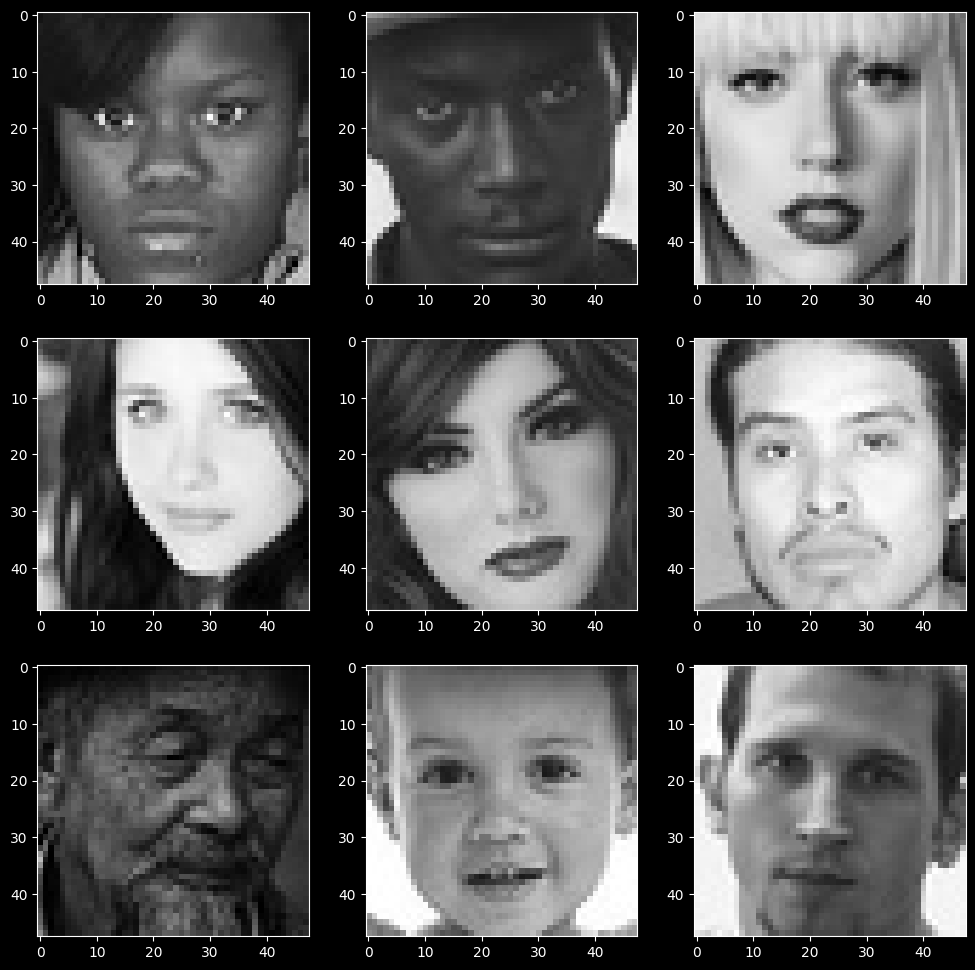

In [ ]:
expression = 'nostress'
plt.style.use('dark_background')
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"test/"+expression+"/"+ os.listdir(folder_path+"test/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()

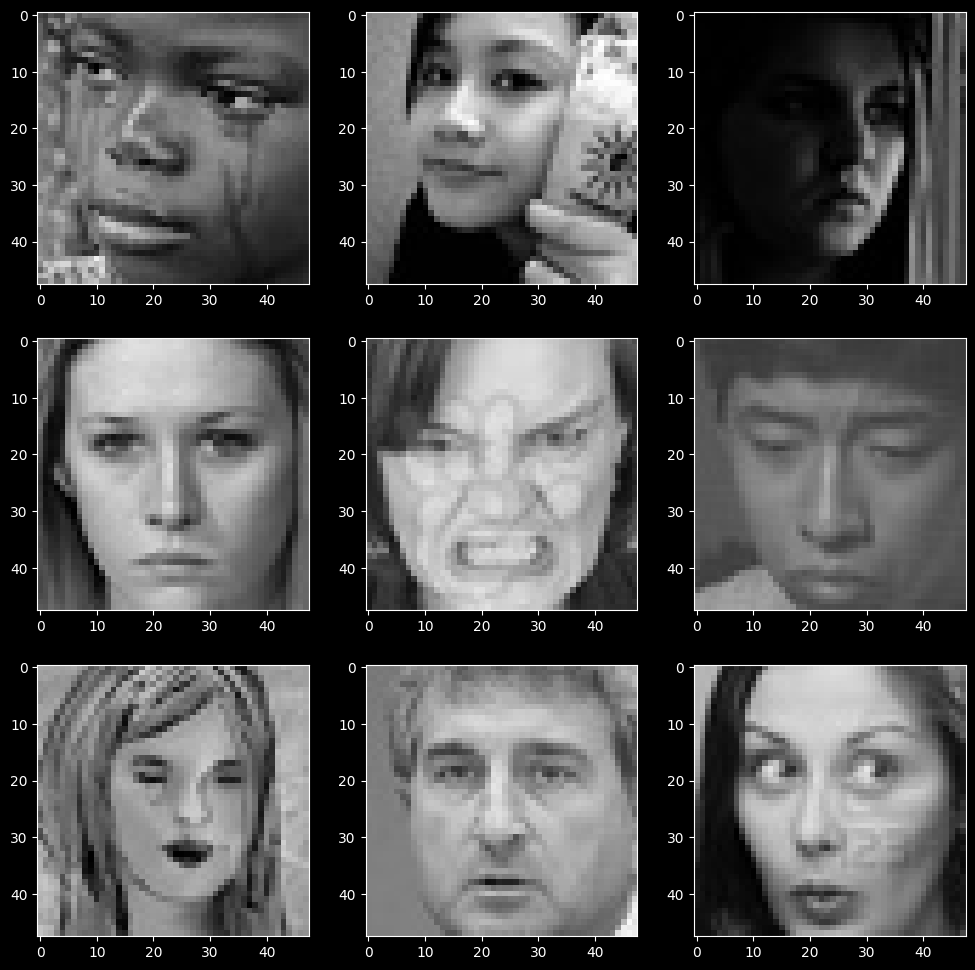

In [ ]:
expression = 'stress'
plt.style.use('dark_background')
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"test/"+expression+"/"+ os.listdir(folder_path+"test/"+expression)[i],target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()

4. Data Augmentation and Preparation

In [ ]:
# Image Augmentation Function
def augumentation(image):
    # This function applies random transformations to a given image.
    # It includes rotation, scaling, and shearing for data augmentation.
    available_transformations = {
        'rotate': tf.image.rot90,
        'flip_left_right': tf.image.flip_left_right,
        'adjust_brightness': lambda img: tf.image.adjust_brightness(img, delta=random.uniform(-0.2, 0.2))
    }
    transformations_to_apply = random.sample(list(available_transformations.keys()), k=random.randint(1, 3))

    for transformation in transformations_to_apply:
        image = available_transformations[transformation](image)
    return image

# Data Preparation
faces = []
emotions = []

# Traverse through the subdirectories (test and train)
for split_dir in os.listdir(folder_path):
    split_path = os.path.join(folder_path, split_dir)
    if os.path.isdir(split_path): # Check if it's a directory
        # Traverse through the emotion subdirectories (stress and nostress)
        for emotion_dir in os.listdir(split_path):
            emotion_path = os.path.join(split_path, emotion_dir)
            if os.path.isdir(emotion_path): # Check if it's a directory
                # Iterate through the image files
                for pic in os.listdir(emotion_path):
                    img_path = os.path.join(emotion_path, pic)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None and img.shape[0] > 0 and img.shape[1] > 0:
                            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                            img_resized = cv2.resize(img_gray, (picture_size, picture_size))
                            faces.append(img_resized)
                            emotions.append(emotion_dir) # Append the emotion directory name as the label
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")

# Convert lists to NumPy arrays
faces = np.array(faces)
emotions = np.array(emotions)

# Convert labels to numerical format
le = LabelEncoder()
emotions_encoded = le.fit_transform(emotions)
emotions_one_hot = to_categorical(emotions_encoded)

# Reshape faces data for the CNN model
faces = np.expand_dims(faces, -1)
faces = faces / 255.0

# Split the data
X_train, X_test, y_train, y_test = train_test_split(faces, emotions_one_hot, test_size=0.2, random_state=42)

5. Building the CNN Model

In [ ]:
# CNN Model Architecture
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(picture_size, picture_size, 1)), # Use Input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(le.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,682 (4.36 MB)

 Trainable params: 1,143,234 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

6. Model Training and Evaluation

In [ ]:
# Training the Model with Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")



Epoch 1/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5945 - loss: 0.9858 - val_accuracy: 0.5100 - val_loss: 1.4862
Epoch 2/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6536 - loss: 0.6344 - val_accuracy: 0.6562 - val_loss: 0.6201
Epoch 3/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6876 - loss: 0.5921 - val_accuracy: 0.6493 - val_loss: 0.6323
Epoch 4/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7256 - loss: 0.5443 - val_accuracy: 0.6880 - val_loss: 0.5972
Epoch 5/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7439 - loss: 0.5098 - val_accuracy: 0.6982 - val_loss: 0.5845
Epoch 6/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7765 - loss: 0.4645 - val_accuracy: 0.6729 - val_loss: 0.6394
Epoch 7/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8054 - loss: 0.4207 - val_accuracy: 0.6888 - val_loss: 0.6119
Epoch 8/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8310 - loss: 0.3705 - val_ac

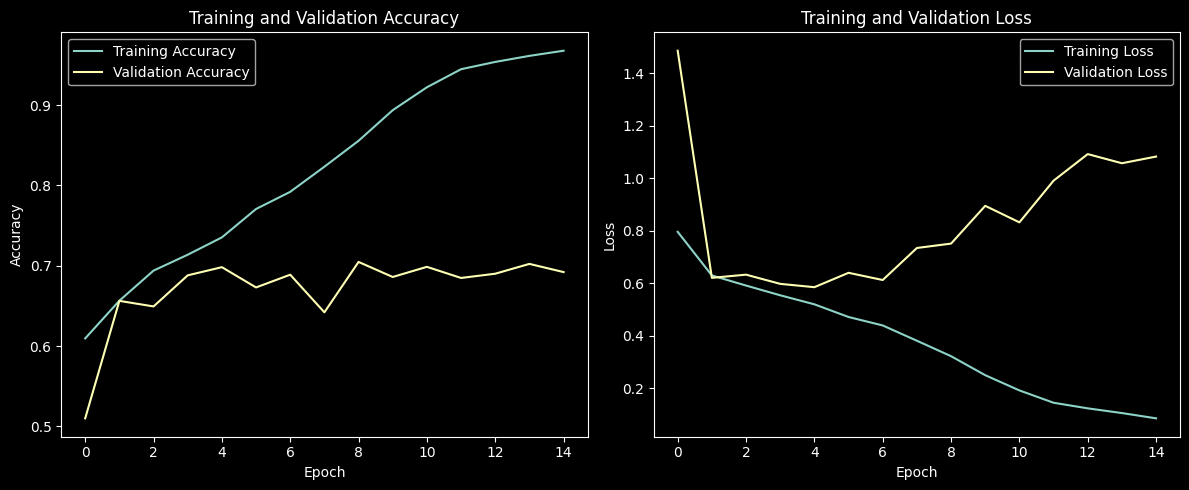

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


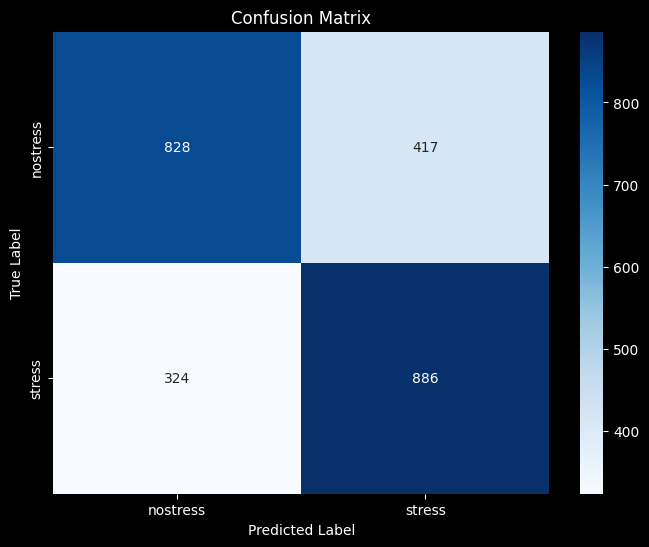

In [ ]:

# Plotting the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions and Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)

# Print the classification report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    nostress       0.72      0.67      0.69      1245
      stress       0.68      0.73      0.71      1210

    accuracy                           0.70      2455
   macro avg       0.70      0.70      0.70      2455
weighted avg       0.70      0.70      0.70      2455



In [ ]:
# Define the path to save the model in .h5 format
model_save_path = 'stress_detection_model.h5'

# Save the model
model.save(model_save_path)

print(f"Model saved successfully at: {model_save_path}")

Model saved successfully at: stress_detection_model.h5
